# Dataset Creation of "easy" CUDA kernels to query 

This notebook grabs the profiling data for the CUDA kernels that we've identified as being "easy" for our prediction pipeline to classify.

In [8]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
from tqdm import tqdm
import csv
import os

In [9]:
GPU_FLOPBENCH_ROOT = os.environ.get('GPU_FLOPBENCH_ROOT')
print(GPU_FLOPBENCH_ROOT)

/gpu-flopbench


In [10]:
# Load the classification results
manual_classifications = os.path.join(GPU_FLOPBENCH_ROOT, 'manual-code-classification', 'manually_classified_CUDA_kernels.json')
with open(manual_classifications, 'r') as f:
    data = json.load(f)

In [11]:
# Parse the loaded JSON (in variable `data`) into a DataFrame of manual classifications
# Expected JSON structure:
# {
#   "categories": [...],
#   "classifications": { "target|filepath|idx": { categoryFlagName: bool, ... }, ... }
# }

categories = data.get('categories', [])
classifications = data.get('classifications', {})

records = []
for composite_key, flags in classifications.items():
    # Split the composite key into its components (robust to extra '|')
    parts = composite_key.split('|')
    target_name = parts[0] if len(parts) > 0 else None
    file_path = parts[1] if len(parts) > 1 else None
    kernel_idx_raw = parts[2] if len(parts) > 2 else None
    try:
        kernel_idx = int(kernel_idx_raw) if kernel_idx_raw is not None else None
    except ValueError:
        kernel_idx = kernel_idx_raw  # leave as string if not int

    row = {
        'targetName': target_name,
        'filepath': file_path,
        'kernel_index': kernel_idx,
    }
    # Ensure all categories appear (even if missing in a particular entry)
    for cat in categories:
        row[cat] = flags.get(cat, None)

    records.append(row)

manual_df = pd.DataFrame(records)

# Create normalized / pythonic boolean columns for easier filtering
import re

def normalize(col: str) -> str:
    # remove leading numeric labels like '1: '
    col_wo_prefix = re.sub(r'^\d+:\s*', '', col)
    return (col_wo_prefix.lower()
            .replace(' ', '_')
            .replace('-', '_')
            .replace('/', '_')
            .replace('__', '_'))

normalized_map = {cat: normalize(cat) for cat in categories}
normalized_map.pop('9: Missing Some Code')

for original, norm in normalized_map.items():
    if original in manual_df.columns:
        manual_df[norm] = manual_df[original].astype(bool)

# Reorder columns: identifiers first, then original category names, then normalized names
original_cat_cols = categories
#normalized_cols = [normalized_map[c] for c in categories]
normalized_cols = list(normalized_map.values())
ordered_cols = ['targetName', 'filepath', 'kernel_index'] + original_cat_cols + normalized_cols
manual_df = manual_df[ordered_cols]

print(f"Parsed {manual_df.shape[0]} classified kernels with {len(categories)} feature flags.")
manual_df.head()

Parsed 717 classified kernels with 9 feature flags.


,targetName,filepath,kernel_index,1: Has Warp Divergence,2: Has Data-Dependent Warp Divergence,3: Has FLOP Division,4: Calls EXTERNAL or LIB function,5: Calls DEVICE function,6: Calls special math function,7: Has Common Subexpression,8: Has Recursion,9: Missing Some Code,has_warp_divergence,has_data_dependent_warp_divergence,has_flop_division,calls_external_or_lib_function,calls_device_function,calls_special_math_function,has_common_subexpression,has_recursion
0,aligned-types-cuda,/Users/gbolet/hecbench-roofline/src/aligned-ty...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False
2,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False
4,particlefilter-cuda,/Users/gbolet/hecbench-roofline/src/particlefi...,0,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


In [12]:
# make a combination column for the binary features

manual_df['combination'] = manual_df[normalized_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)


test = manual_df[manual_df['combination'] == '10000000']
print(test.shape)

assert manual_df[manual_df['combination'] == '10000000'].shape[0] == 156, "Sanity check failed!"

(156, 21)


/tmp/ipykernel_96/1984192966.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='feature', y='count', data=feature_counts_df, palette='Blues_d')


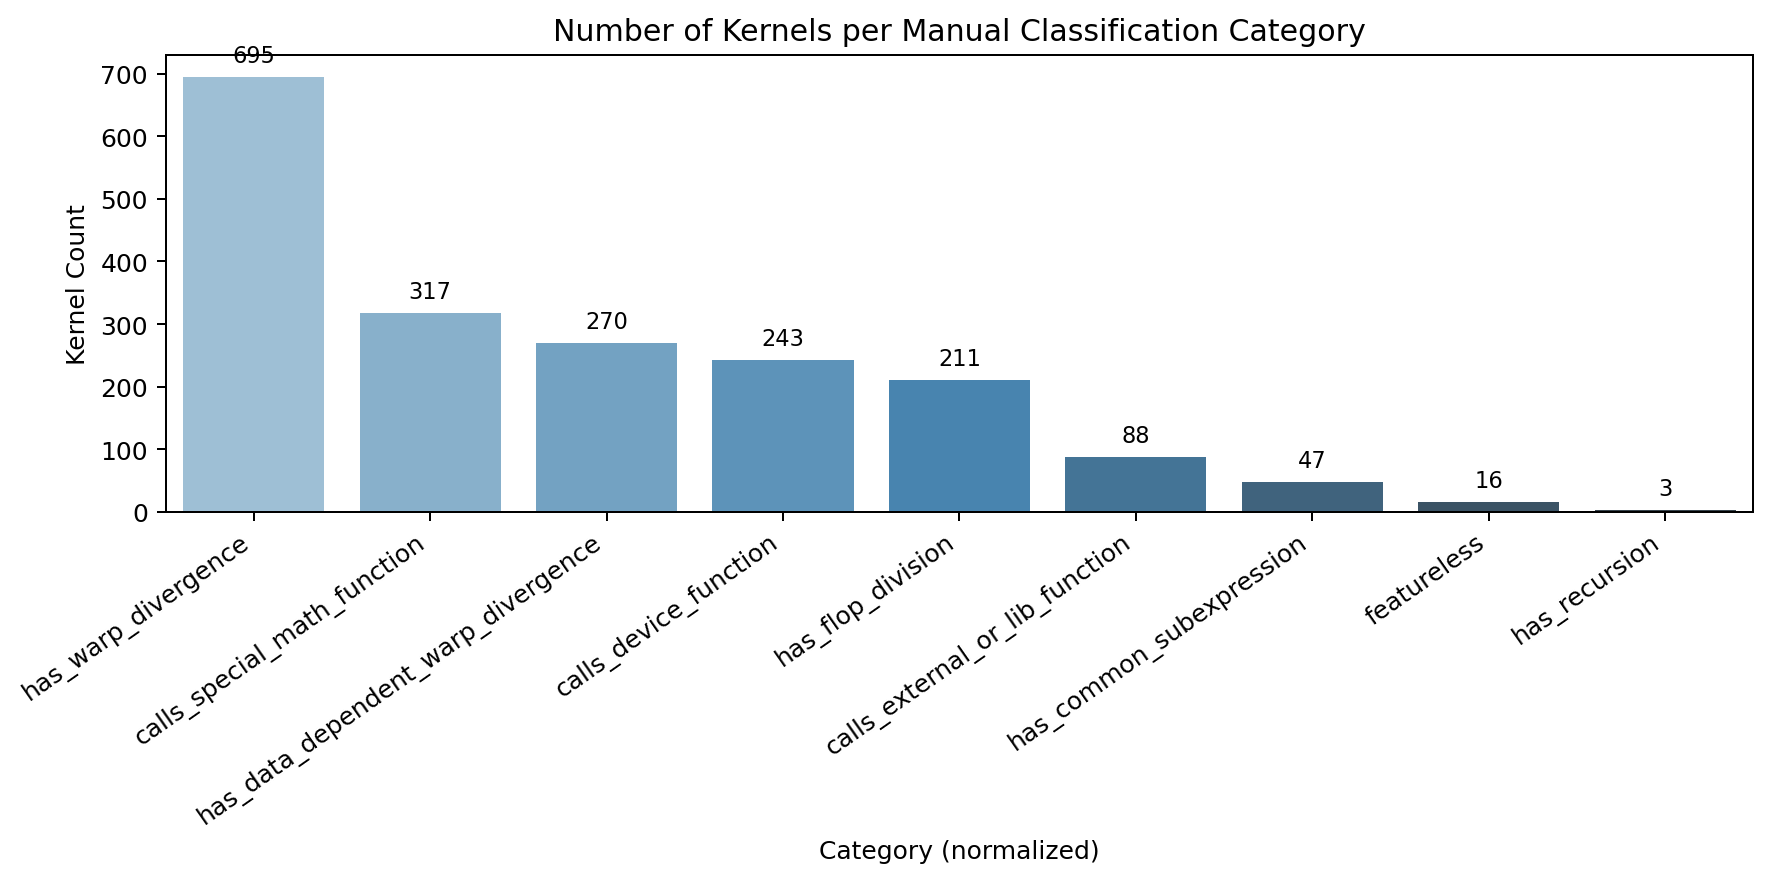

,feature,count
0,has_warp_divergence,695
1,calls_special_math_function,317
2,has_data_dependent_warp_divergence,270
3,calls_device_function,243
4,has_flop_division,211


In [13]:
# Barplot: count of codes per (normalized) category (+ featureless case)
# Use the normalized boolean columns created earlier (normalized_cols)

assert 'manual_df' in globals(), "manual_df not found. Run previous cell first."
assert 'normalized_cols' in globals(), "normalized_cols list not found."

# Ensure columns exist
existing_norm_cols = [c for c in normalized_cols if c in manual_df.columns]

# Sum booleans (True counts) per feature
feature_counts_df = (manual_df[existing_norm_cols]
                     .astype(int)
                     .sum()
                     .reset_index())
feature_counts_df.columns = ['feature', 'count']

# Add the featureless category: rows where all normalized features are False
featureless_count = (manual_df[existing_norm_cols].astype(int).sum(axis=1) == 0).sum()
feature_counts_df = pd.concat([
    feature_counts_df,
    pd.DataFrame([{'feature': 'featureless', 'count': featureless_count}])
], ignore_index=True)

# Order by count descending (featureless included)
feature_counts_df = feature_counts_df.sort_values('count', ascending=False, ignore_index=True)

plt.figure(figsize=(10, 5), dpi=180)
ax = sns.barplot(x='feature', y='count', data=feature_counts_df, palette='Blues_d')
plt.title('Number of Kernels per Manual Classification Category')
plt.xlabel('Category (normalized)')
plt.ylabel('Kernel Count')
plt.xticks(rotation=35, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,4), textcoords='offset points')

plt.tight_layout()
plt.show()

feature_counts_df.head()

    has_warp_divergence  has_data_dependent_warp_divergence  \
5                  True                               False   
30                 True                                True   
7                  True                               False   
32                 True                                True   
9                  True                               False   

    has_flop_division  calls_external_or_lib_function  calls_device_function  \
5               False                           False                  False   
30              False                           False                  False   
7               False                           False                  False   
32              False                           False                  False   
9               False                           False                   True   

    calls_special_math_function  has_common_subexpression  has_recursion  \
5                         False                     False       

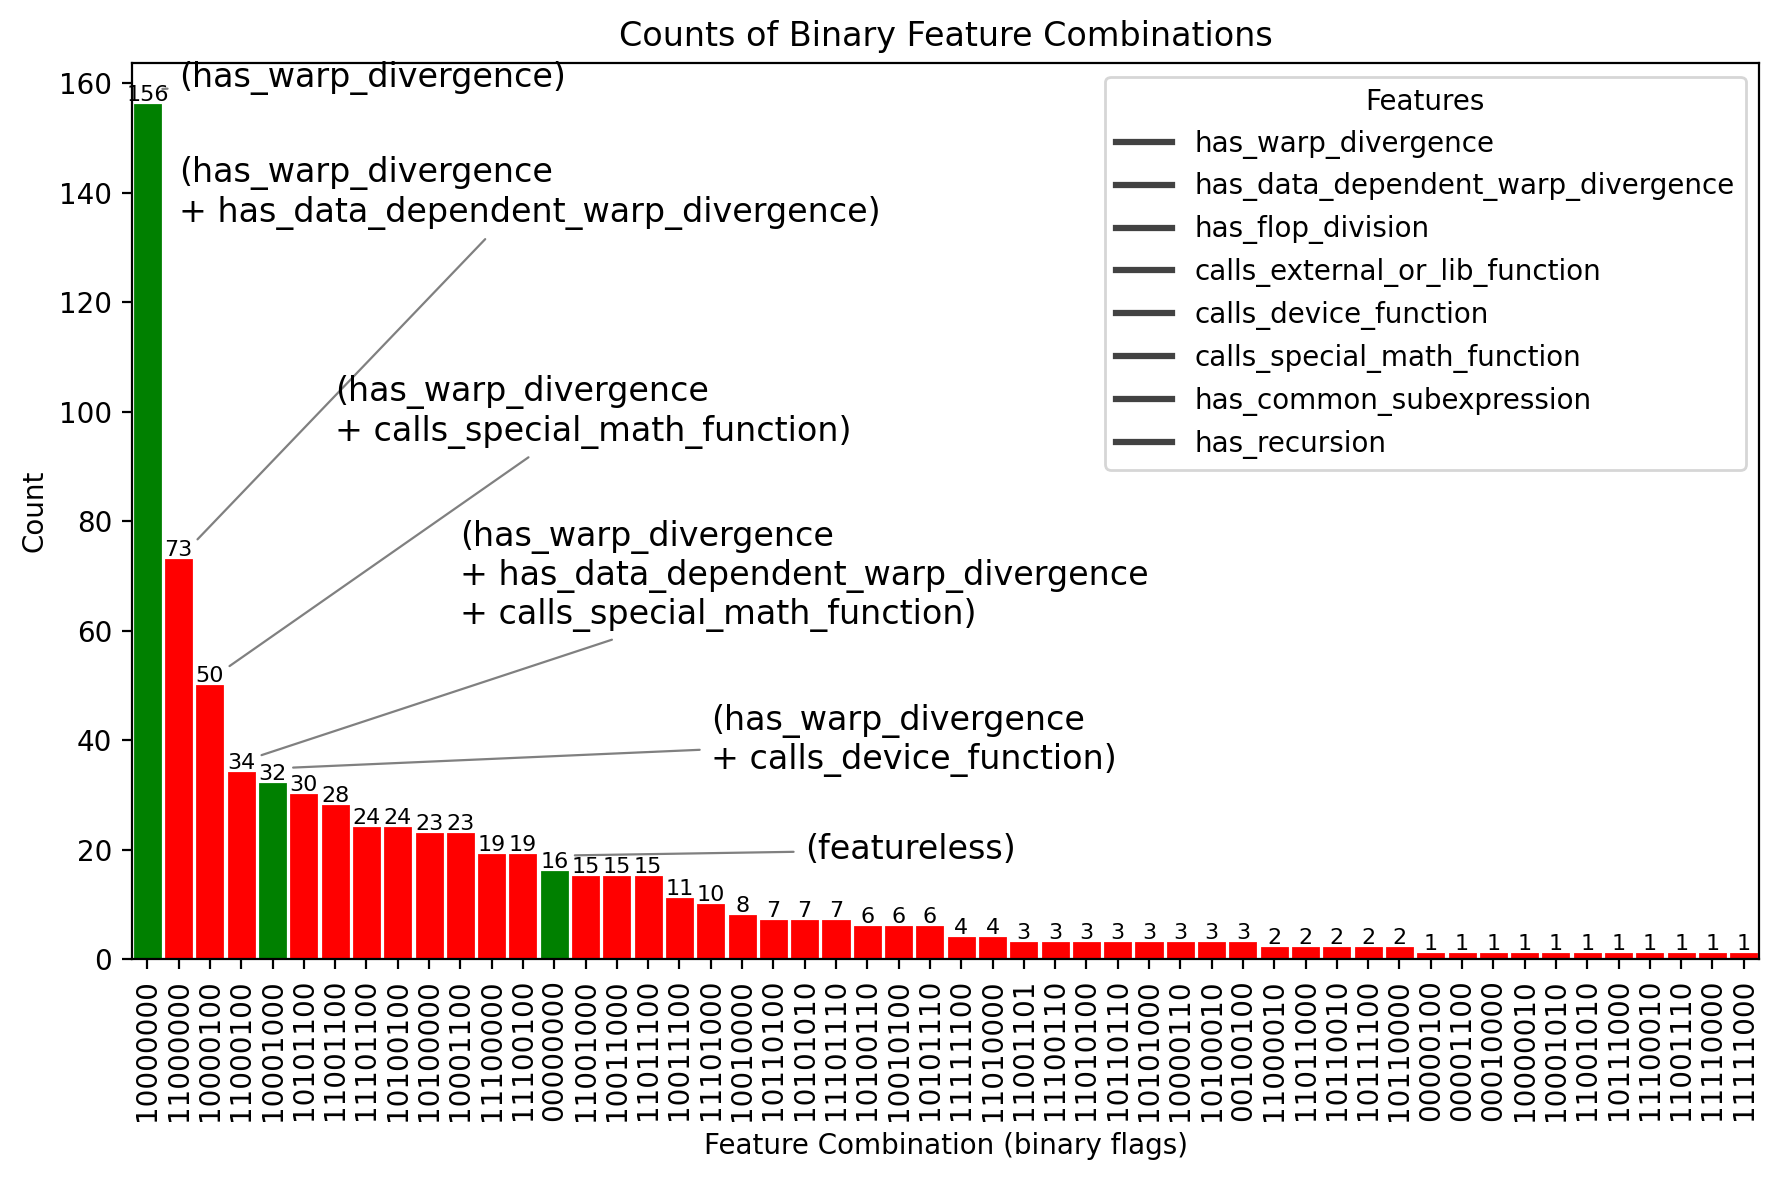

In [14]:
import textwrap

no_hidden_flop_combinations = ['10000000', '10001000', '00001000', '00000000']

df_grouped = manual_df.groupby(normalized_cols).size().reset_index(name='count')
df_grouped_sorted = df_grouped[df_grouped['count'] > 0].sort_values(by='count', ascending=False)

df_grouped_sorted['combination'] = df_grouped_sorted[normalized_cols].apply(
    lambda row: ''.join(row.astype(int).astype(str)), axis=1)

print(df_grouped_sorted.head(5))

plt.figure(figsize=(9, 6), dpi=200)
ax = sns.barplot(x='combination', y='count', data=df_grouped_sorted)
plt.title('Counts of Binary Feature Combinations')
plt.xlabel('Feature Combination (binary flags)')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='center')

# Annotate feature tuples (first four only) at right edge inside plot with arrows, and counts above bars
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# shift label_x slightly inside the right boundary
label_x = xlim[1] - (xlim[1] - xlim[0]) * 0.05
# define stagger offsets to prevent text overlap
stagger_offsets = [1, 1, 6, 10, 18, 21]  # stagger offsets for the first five bars

custom_text_heights = [158+3, 140, 100, 70, 40, 20]

for i, (p, (_, row)) in enumerate(zip(ax.patches, df_grouped_sorted.iterrows())):
    height = p.get_height()
    # set the bar color if the x-axis label (combination) is in no_hidden_flop_combinations
    if row['combination'] in no_hidden_flop_combinations:
        p.set_color('green')
    else:
        p.set_color('red')
    feature_names = [name for name, flag in zip(normalized_cols, row[normalized_cols]) if flag]
    tuple_text = f"({(chr(10)+'+ ').join(feature_names)})" if feature_names else '()'
    # draw arrow annotation for first five bars
    if i < 5 or row['combination'] == '00000000':
        if row['combination'] == '00000000':
            i = 5
            tuple_text = '(featureless)'

        ax.annotate(tuple_text,
                    xy=(p.get_x() + p.get_width()*1.1, height+3),
                    xytext=(stagger_offsets[i], custom_text_heights[i]),
                    ha='left', va='center', color='black', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.8))
    # annotate count above bar
    ax.annotate(f"{int(height)}",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', color='black', fontsize=8)


ax.legend(normalized_cols, title='Features')
plt.tight_layout()
plt.show()

In [15]:
# let's categorize the codes as being "easy" or "hard" to count FLOPs

no_hidden_flop_combinations = ['10000000', '10001000', '00001000', '00000000']

manual_df['isEasy'] = manual_df['combination'].apply(lambda comb: comb in no_hidden_flop_combinations)

print(manual_df['isEasy'].value_counts())

isEasy
False    513
True     204
Name: count, dtype: int64


In [16]:
# let's check how many individual executables there are
manual_df[manual_df['isEasy'] == True]['targetName'].nunique()

95

/tmp/ipykernel_96/3250769792.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=easy_targets, order=easy_targets.value_counts().index, palette='viridis')


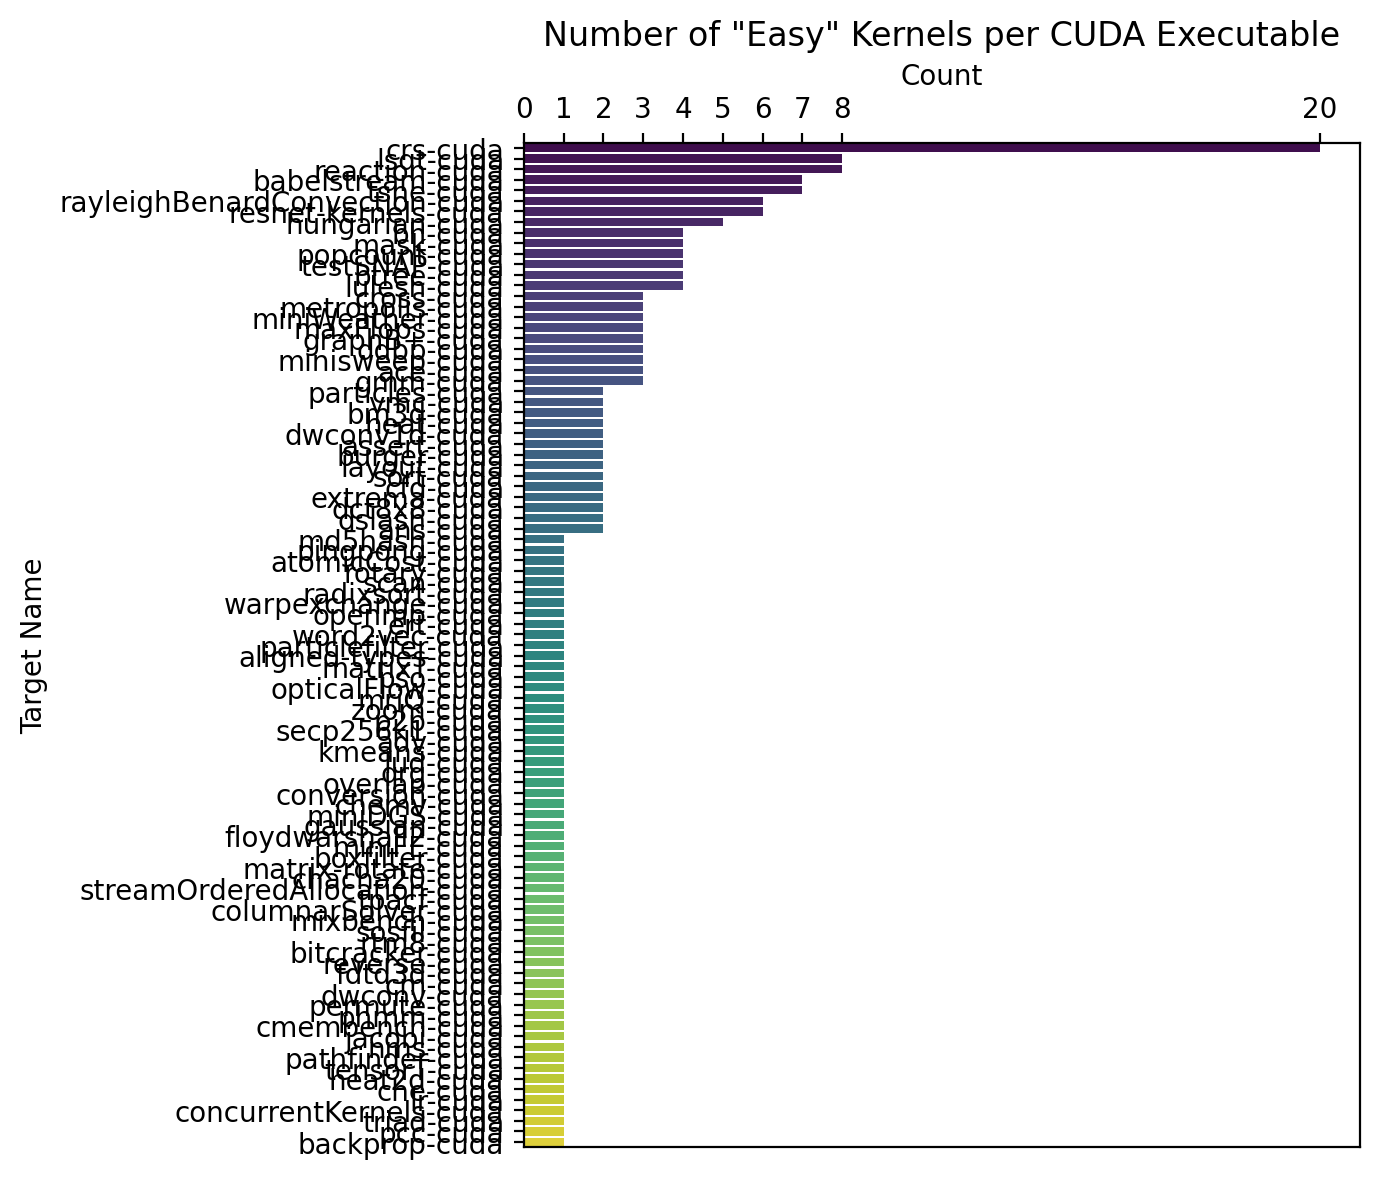

In [17]:
# plot the distribution of the targetNames in the easy category

plt.figure(figsize=(7, 6), dpi=200)
easy_targets = manual_df[manual_df['isEasy'] == True]['targetName']
ax = sns.countplot(y=easy_targets, order=easy_targets.value_counts().index, palette='viridis')
plt.title('Number of "Easy" Kernels per CUDA Executable')
plt.xlabel('Count')
plt.ylabel('Target Name')

xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 20]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=0, fontsize=10)

# put the x-axis on top of the plot
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()

In [18]:
# let's check which codes are in the builtCUDACodes.txt file

builtCUDACodesTXT = os.path.join(GPU_FLOPBENCH_ROOT, 'cuda-profiling', 'builtCUDACodes.txt')

# read the builtCUDACodes.txt file into a string variable
with open(builtCUDACodesTXT, 'r') as f:
    built_codes_content = f.read()

# split the content into a list of codes
built_codes = set(built_codes_content.splitlines())

easy_targets_names = set(easy_targets.unique().tolist())


print(f"Number of unique 'easy' targetNames: {len(easy_targets_names)}")
print(f"Number of unique built CUDA codes: {len(built_codes)}")

# set difference: which easy targetNames are not in built_codes
missing_codes = easy_targets_names.difference(built_codes)
print(f"Number of 'easy' targetNames MISSING FROM built CUDA codes: {len(missing_codes)}")


# get the number of kernels per missing code
missing_kernels = manual_df[(manual_df['isEasy'] == True) & (manual_df['targetName'].isin(missing_codes))].groupby('targetName').size().reset_index(name='count')

print("Missing CUDA codes:")
print(missing_kernels)
print("total missing easy kernels:", missing_kernels['count'].sum())



Number of unique 'easy' targetNames: 95
Number of unique built CUDA codes: 445
Number of 'easy' targetNames MISSING FROM built CUDA codes: 5
Missing CUDA codes:
         targetName  count
0           cm-cuda      1
1     dwconv1d-cuda      2
2      miniDGS-cuda      1
3  miniWeather-cuda      3
4     pingpong-cuda      1
total missing easy kernels: 8


## Extract the kernel names from the source codes

In [11]:
import sys
sys.path.append("..")  # Adjust the path to import from the parent directory

# Now let's cross-reference this list of easy kernels with the extracted_CUDA_kernels.json file
from utils.dataset import kernels_data  

from static_passes.TargetKernel import TargetKernel

#from tree_sitter import Language, Parser
#import tree_sitter_cuda
#
#CUDA_LANGUAGE = Language(tree_sitter_cuda.language())
#parser = Parser(CUDA_LANGUAGE)

In [12]:
easy_codes = manual_df[manual_df['isEasy'] == True][['targetName', 'filepath', 'kernel_index']]

easy_codes['kernelName'] = ''

print(easy_codes.columns)
print()

Index(['targetName', 'filepath', 'kernel_index', 'kernelName'], dtype='object')



In [13]:
# for each easy_code, get the corresponding source from the kernels_data object 

for index, row in easy_codes.iterrows():
    target_name = row['targetName']
    filepath = row['filepath']
    kernel_index = row['kernel_index']

    # get the corresponding source code from kernels_data
    target_files_dict = kernels_data[target_name]
    kernels_list = target_files_dict[filepath]
    source_code = kernels_list[kernel_index]
    kernel_name = TargetKernel.get_global_func_name(source_code)

    easy_codes.at[index,'kernelName'] = kernel_name

    #print(f"Target: {target_name}, File: {filepath}, Kernel Index: {kernel_index}, \n\tKernel Name: {kernel_name}\n\n")



In [14]:
easy_codes['combined_name'] = '(' + easy_codes['targetName'] + ', ' + easy_codes['kernelName'] + ')'

print(easy_codes['combined_name'].head())
print(easy_codes['combined_name'].tail())

0      (aligned-types-cuda, testKernel)
2     (particlefilter-cuda, kernel_sum)
9               (gmm-cuda, mstep_means)
10                  (gmm-cuda, mstep_N)
11        (gmm-cuda, mstep_covariance1)
Name: combined_name, dtype: object
698            (extrema-cuda, relextrema_2D)
699    (concurrentKernels-cuda, clock_block)
701                      (triad-cuda, triad)
703                         (pcc-cuda, ker2)
712     (backprop-cuda, kernel_layerforward)
Name: combined_name, dtype: object


## Import the profiled kernel data

In [15]:
# we put a restriciton that the kernels must have a nonzero number of SP-FLOP or DP-FLOP operations

dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }

# load the profiled kernels data
# note that for resnet-kernels-cuda we had to manually edit the exeArgs to be correct
df = pd.read_csv('../../../../roofline-data-updated-FINAL.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

# we only want the CUDA codes
df = df[df['language'] == 'CUDA']

# add a column with the combined_name
df['combined_name'] = df.apply(lambda row: f"({row['targetName']}, {row['kernelName']})", axis=1)

# xtime units of ns
# spPerf in units of OP/s
df['SP_FLOP'] = df['spPerf'] * 1e-9 * df['xtime']
df['SP_FLOP'] = df['SP_FLOP'].apply(int)

df['DP_FLOP'] = df['dpPerf'] * 1e-9 * df['xtime']
df['DP_FLOP'] = df['DP_FLOP'].apply(int)

print(df[df['targetName'] == 'aligned-types-cuda'])

print(df.shape)

                                           Kernel Name       traffic  dpAI  \
510  void testKernel<unsigned char>(T1 *, const T1 ...  3.277521e+11   0.0   
511  void testKernel<unsigned char>(T1 *, const T1 ...  3.292841e+11   0.0   

     spAI  dpPerf  spPerf     xtime   Block Size       Grid Size  \
510   0.0     0.0     0.0  303136.0  (256, 1, 1)  (195312, 1, 1)   
511   0.0     0.0     0.0  303328.0  (256, 1, 1)  (195312, 1, 1)   

                      device       intops       intPerf     intAI  \
510  NVIDIA GeForce RTX 3080  399998976.0  1.319536e+12  4.026019   
511  NVIDIA GeForce RTX 3080  399998976.0  1.318701e+12  4.004752   

             targetName exeArgs  kernelName language  \
510  aligned-types-cuda    <NA>  testKernel     CUDA   
511  aligned-types-cuda    <NA>  testKernel     CUDA   

                        combined_name  SP_FLOP  DP_FLOP  
510  (aligned-types-cuda, testKernel)        0        0  
511  (aligned-types-cuda, testKernel)        0        0  
(1862, 20

# Manaully fix some kernel names that stayed mangled

In [16]:
import subprocess

def fix_kernel_name(row):
    kname = row['Kernel Name']
    # if the kernel signature is missing the parentheses, it most likely is still mangled
    # it seems that cu++filt doesn't demangle all the names correctly, so we need to use c++filt
    # or llvm-cxxfilt
    if not ('(' in kname and ')' in kname) and ('_Z' in kname[0:2]):
        # add an underscore at the start to correctly demangle
        demangleCommand = f'c++filt _{kname}'
        knamesResult = subprocess.run(demangleCommand, shell=True, 
                                  timeout=60, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

        assert knamesResult.returncode == 0

        demangled = knamesResult.stdout.decode('UTF-8').strip()
        row['Kernel Name'] = demangled

        assert '(' in demangled and ')' in demangled, f"Failed to demangle kernel name: {kname} -> {demangled}"

        print(f'Fixed Kernel Name: {kname} \t-->\t {row["Kernel Name"]}', flush=True)

    return row

In [17]:
df = df.apply(fix_kernel_name, axis=1)

Fixed Kernel Name: _ZL14timedReductionPKfPfPl 	-->	 timedReduction(float const*, float*, long*)
Fixed Kernel Name: _ZL12inTreeUpdateiPKiPVi 	-->	 inTreeUpdate(int, int const*, int volatile*)
Fixed Kernel Name: _ZL12inTreeUpdateiPKiPVi 	-->	 inTreeUpdate(int, int const*, int volatile*)
Fixed Kernel Name: _ZL5init3iPKiS0_PiS1_ 	-->	 init3(int, int const*, int const*, int*, int*)
Fixed Kernel Name: _ZL5init3iPKiS0_PiS1_ 	-->	 init3(int, int const*, int const*, int*, int*)
Fixed Kernel Name: _ZL11incrementCCiPKiS0_Pi 	-->	 incrementCC(int, int const*, int const*, int*)
Fixed Kernel Name: _ZL11incrementCCiPKiS0_Pi 	-->	 incrementCC(int, int const*, int const*, int*)
Fixed Kernel Name: _Z12block_strideI7__half2TnNSt9enable_ifIXsr3std7is_sameIT_S0_EE5valueEiE4typeELi0EEvjjPS2_ 	-->	 void block_stride<__half2, 0>(unsigned int, unsigned int, __half2*)
Fixed Kernel Name: _Z12block_strideI7__half2TnNSt9enable_ifIXsr3std7is_sameIT_S0_EE5valueEiE4typeELi0EEvjjPS2_ 	-->	 void block_stride<__half2, 0

In [18]:
# get the first sample of each kernel execution
grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs'], dropna=False).first().reset_index()

print(grouped.head())
print(grouped.shape)

df = grouped.reset_index(drop=True)

print(df[df['targetName'] == 'aligned-types-cuda'])

#df = df.merge(grouped, on=list(grouped.columns), how='inner')
#
#
print(df.columns)
print(df[['kernelName', 'Kernel Name']])
print(df.shape)

                                         Kernel Name  \
0  AESEncrypt(uchar4 *, const uchar4 *, const uch...   
1  AIDW_Kernel(const float *, const float *, cons...   
2  AIDW_Kernel_Tiled(const float *, const float *...   
3  AddKernel(const float *, const float *, int, f...   
4                                    AddOne(float *)   

                      targetName                            exeArgs  \
0                       aes-cuda  100 0 ../urng-sycl/URNG_Input.bmp   
1                      aidw-cuda                           10 1 100   
2                      aidw-cuda                           10 1 100   
3               opticalFlow-cuda                                NaN   
4  rayleighBenardConvection-cuda                               1000   

        traffic  dpAI          spAI  dpPerf        spPerf      xtime  \
0  2.272939e+09   0.0      0.000000     0.0  0.000000e+00   549632.0   
1  7.804676e+07   0.0  26055.523837     0.0  2.033549e+12  3713056.0   
2  9.495886e+07   0.

## Get the counter data for each kernel

In [19]:
print(easy_codes.shape)

easy_codes_with_counter_data = df[df['combined_name'].isin(easy_codes['combined_name'])]

print(easy_codes_with_counter_data.shape)

(204, 5)
(186, 20)


In [20]:
# which codes didn't get any counter data?

easy_codes_missing_counter_data = easy_codes[~easy_codes['combined_name'].isin(df['combined_name'])]

print(easy_codes_missing_counter_data.shape)

print(f"Number of problem targets:", easy_codes_missing_counter_data.targetName.nunique())
print(f"Problem targets:\n", '\n'.join(easy_codes_missing_counter_data.targetName.unique()))

print()

for item in easy_codes_missing_counter_data['combined_name']:
    print(item)

(22, 5)
Number of problem targets: 16
Problem targets:
 gmm-cuda
btree-cuda
bm3d-cuda
metropolis-cuda
p2p-cuda
pingpong-cuda
rayleighBenardConvection-cuda
miniWeather-cuda
miniFE-cuda
assert-cuda
dwconv1d-cuda
miniDGS-cuda
lsqt-cuda
reaction-cuda
cm-cuda
pcc-cuda

(gmm-cuda, mstep_covariance1)
(btree-cuda, delete_b_tree)
(btree-cuda, range_b_tree)
(bm3d-cuda, IDCT2D8x8)
(metropolis-cuda, kernel_reset_random_gpupcg)
(p2p-cuda, SimpleKernel)
(pingpong-cuda, test)
(rayleighBenardConvection-cuda, AddX)
(miniWeather-cuda, pack_send_buf)
(miniWeather-cuda, unpack_recv_buf)
(miniWeather-cuda, update_fluid_state)
(miniFE-cuda, Tkern1D)
(assert-cuda, perfKernel2)
(dwconv1d-cuda, kernel_forward)
(dwconv1d-cuda, kernel_backward)
(miniDGS-cuda, MaxwellsGPU_RK_Kernel3D)
(lsqt-cuda, gpu_apply_sz)
(reaction-cuda, derivative_x2_pbc)
(reaction-cuda, derivative_y2_pbc)
(reaction-cuda, derivative_z2_pbc)
(cm-cuda, computeDotProductHelper)
(pcc-cuda, ker2)


## Let's visualize the counter data of the "easy" kernels

In [21]:

def plot_sp_dp_nnz_flop_distribution(df):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)

    nnz_sp_data = df[df['SP_FLOP'] != 0]['SP_FLOP'].astype(float)
    nnz_dp_data = df[df['DP_FLOP'] != 0]['DP_FLOP'].astype(float)

    print(len(nnz_sp_data))
    print(len(nnz_dp_data))

    nnz_sp_data = np.log1p(nnz_sp_data)/np.log1p(10)
    nnz_dp_data = np.log1p(nnz_dp_data)/np.log1p(10)

    print(nnz_sp_data.shape)
    print(nnz_dp_data.shape)

    merged = pd.DataFrame({
        'flop_count': np.concatenate([nnz_sp_data, nnz_dp_data]),
        'type': ['SP'] * len(nnz_sp_data) + ['DP'] * len(nnz_dp_data)
    })

    # make a box and whisker plot seaborn

    sns.boxplot(x=merged['flop_count'], hue=merged['type'], ax=ax)

    #ax.set_xscale('symlog')

    #overlay a cdf plot, use other y axis
    ax2 = ax.twinx()
    sns.ecdfplot(x=merged['flop_count'], hue=merged['type'], ax=ax2, linestyle='-', linewidth=2, palette='Set2')

    ax2.legend(title='FLOP Type', loc='upper left')

    ax.set_title('Distribution of Non-zero SP and DP FLOP Counts for "Easy" Kernels')
    ax.set_xlabel('FLOP Count (log scale)')
    ax.set_ylabel('FLOP Type')

    xticks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    ax.set_xticks(xticks)
    ax.set_xticklabels([r'$10^{'+str(i)+'}$' for i in xticks])

    # set the name of the legend, location to bottom right
    ax.legend(title='FLOP Type', loc='lower right')

    plt.tight_layout()

    plt.show()

63
20
(63,)
(20,)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/589268085.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='FLOP Type', loc='upper left')


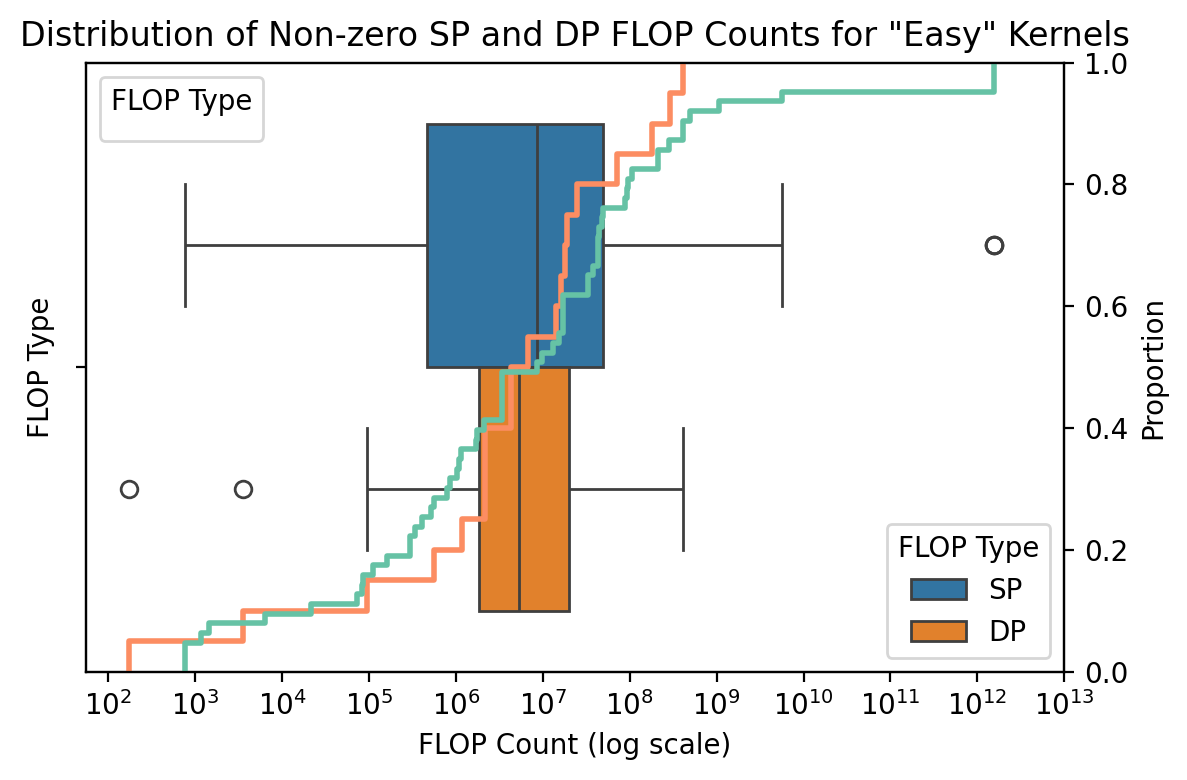

In [22]:
plot_sp_dp_nnz_flop_distribution(easy_codes_with_counter_data)

In [23]:
# Categorize flop presence (ensure column exists)
def categorize_flop_state(row):
    if row['SP_FLOP'] == 0 and row['DP_FLOP'] == 0:
        return 'Zero SP + DP FLOP'
    elif row['SP_FLOP'] != 0 and row['DP_FLOP'] != 0:
        return 'Non-zero SP + DP FLOP'
    elif row['SP_FLOP'] != 0:
        return 'Non-zero SP FLOP'
    elif row['DP_FLOP'] != 0:
        return 'Non-zero DP FLOP'
    else:
        return 'Unknown'

# (re)compute the column in case the notebook was re-run out of order
easy_codes_with_counter_data['nnz_flop_state'] = easy_codes_with_counter_data.apply(categorize_flop_state, axis=1)


def plot_flop_type_distribution(df):
    # We care about three non-zero categories: both, SP-only, DP-only
    grouped = df.groupby(['nnz_flop_state']).count()
    categories = grouped.index.tolist() + ['Non-zero SP + DP FLOP']
    counts = grouped.iloc[:,0].tolist() + [0]

    # Quick summary table (optional helpful print)
    summary_df = pd.DataFrame({'category': categories, 'count': counts})
    print(summary_df)

    # Create a seaborn-styled stacked bar (matplotlib bar with seaborn style)
    plt.figure(figsize=(4, 4), dpi=200)
    import seaborn as sns
    sns.set_style('whitegrid')

    bottom = 0
    colors = sns.color_palette('Set2', n_colors=4)
    for val, cat, c in zip(counts, categories, colors):

        if val == 0:
            # make an arrow pointing to the zero segment
            # make the arrow start at the left edge of the text
            plt.annotate(f'{cat}\n({str(val)} kernels)', xy=(0.4, 0), xytext=(0.6, 0.2),
                         arrowprops=dict(facecolor='black', color='black', arrowstyle='->', relpos=(0,0)),
                         ha='center', va='bottom', fontsize=10, color='black', rotation=90)
            continue
        plt.bar(0, val, bottom=bottom, color=c, label=f"{cat} ({val})")
        # annotate each stacked segment in the middle
        #if val > 0:
        #    plt.text(0, bottom + val / 4, str(val), ha='center', va='center', fontsize=10, color='black')
        bottom += val

        # annotate the category name within each bar segment
        plt.text(0, bottom - val / 2, f'{cat}\n({str(val)} kernels)', ha='center', va='center', fontsize=12)

    plt.xticks([])  # hide x ticks since it's a single combined bar
    plt.ylabel('Number of Kernels')
    plt.title('FLOP Types among "Easy" Kernels')

    # draw the legend outside the plot area on the right
    #plt.legend(title='FLOP Category', bbox_to_anchor=(1.05, 0.5), loc='upper left')
    plt.tight_layout()
    plt.show()

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/1465215327.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easy_codes_with_counter_data['nnz_flop_state'] = easy_codes_with_counter_data.apply(categorize_flop_state, axis=1)


                category  count
0       Non-zero DP FLOP     20
1       Non-zero SP FLOP     63
2      Zero SP + DP FLOP    103
3  Non-zero SP + DP FLOP      0


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/1465215327.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.annotate(f'{cat}\n({str(val)} kernels)', xy=(0.4, 0), xytext=(0.6, 0.2),


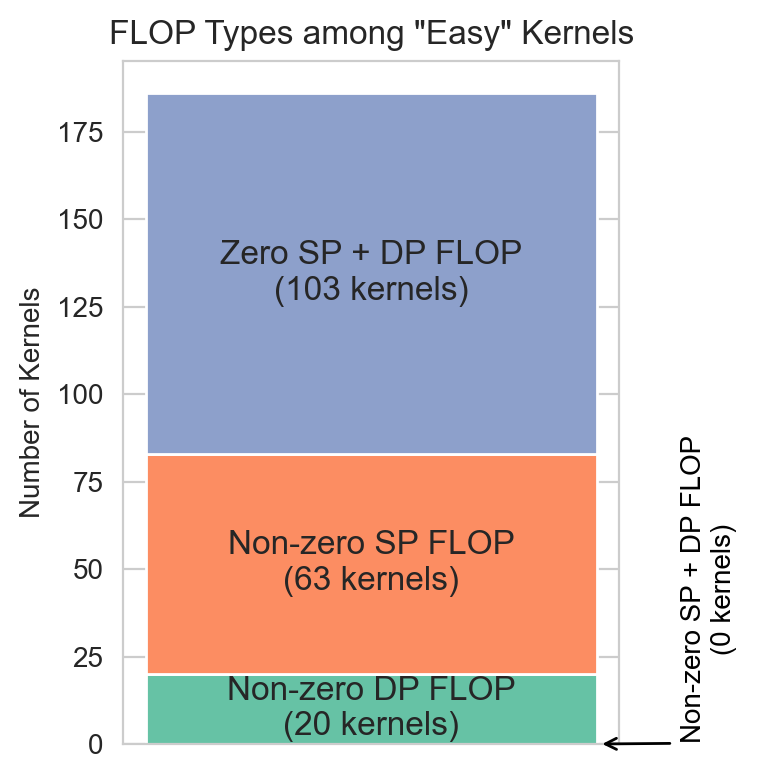

In [24]:
plot_flop_type_distribution(easy_codes_with_counter_data)

## Gather the source codes for the target kernels

In [25]:
file_path = '../../../../analysis/simple-scraped-kernels-CUDA-only.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    src_data = json.load(file)

In [26]:
merged_df = pd.DataFrame()

enc = tiktoken.encoding_for_model("gpt-4o-mini")

assert '(gmm-cuda, mstep_means)' in easy_codes_with_counter_data['combined_name'].values, "Sanity check failed!"

for idx, row in tqdm(easy_codes_with_counter_data.iterrows(), total=easy_codes_with_counter_data.shape[0]):
    target_name = row['targetName']
    kernelName = row['kernelName']

    src_code = ''
    for data in src_data:
        basename = data['basename']
        kNames = data['kernelNames']

        if target_name == basename:
            if kernelName in kNames:
                src_code = data['kernels'][kernelName]

                assert kernelName in src_code
                assert 'main' in src_code
                if row['SP_FLOP'] != 0 or row['DP_FLOP'] != 0:
                    assert 'float' in src_code or 'double' in src_code, f"FLOP ops expected but not found in source for {target_name}, {kernelName}"
                break

    assert src_code != '', f"Source code not found for {target_name}, {kernelName}"
    # add source code to this row
    row_dict = row.to_dict()
    row_dict['source_code'] = [src_code]
    row_dict['num_tokens'] = [len(enc.encode(src_code))]

    merged_df = pd.concat([merged_df, pd.DataFrame(row_dict)], ignore_index=True)


100%|██████████| 186/186 [00:02<00:00, 71.81it/s] 


In [27]:
print(merged_df.columns)
print(merged_df.head(5))

Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens'],
      dtype='object')
                                         Kernel Name  \
0  AddKernel(const float *, const float *, int, f...   
1                                    AddOne(float *)   
2                      ClearKernel1(int, int, int *)   
3          ClearKernel2(int, int *, float4 *, int *)   
4  ComputePhiMag_GPU(const float *, const float *...   

                      targetName  \
0               opticalFlow-cuda   
1  rayleighBenardConvection-cuda   
2                        bh-cuda   
3                        bh-cuda   
4                      mriQ-cuda   

                                             exeArgs       traffic  dpAI  \
0                                           

## Manually add some header file data to the source-codes of some kernels

In [28]:
# testSNAP-cuda includes a header file in its source code, so we need to manually add it
# the problem is that said header file is really big, so we will only take the first 54 lines
# that have the relevant information we care about

testSNAP_header_file_path = '../../../../src/testSNAP-omp/refdata_2J14_W.h'

with open(testSNAP_header_file_path, 'r') as f:
    header_content = f.read()

testSNAP_header_file_data = """
-----------------------------------
refdata_2J14_W.h
-----------------------------------
""" + ''.join(header_content.splitlines(keepends=True)[:54]) + """
.... (following contents omitted for brevity) ....
"""

print(testSNAP_header_file_data)

def apply_testSNAP_header_fix(row):
    if 'testSNAP-cuda' in row['combined_name']:
        original_source = row['source_code']
        fixed_source = testSNAP_header_file_data + '\n' + original_source
        row['source_code'] = fixed_source
        row['num_tokens'] = len(enc.encode(fixed_source))
        print(f"Applied testSNAP header fix to {row['combined_name']}. New token count: {row['num_tokens']}")

    return row

merged_df = merged_df.apply(apply_testSNAP_header_fix, axis=1)


-----------------------------------
refdata_2J14_W.h
-----------------------------------
// ----------------------------------------------------------------------
// Copyright (2019) Sandia Corporation. 
// Under the terms of Contract DE-AC04-94AL85000 
// with Sandia Corporation, the U.S. Government 
// retains certain rights in this software. This 
// software is distributed under the Zero Clause 
// BSD License
//
// TestSNAP - A prototype for the SNAP force kernel
// Version 0.0.2
// Main changes: Y array trick, memory compaction 
//
// Original author: Aidan P. Thompson, athomps@sandia.gov
// http://www.cs.sandia.gov/~athomps, Sandia National Laboratories
//
// Additional authors: 
// Sarah Anderson
// Rahul Gayatri
// Steve Plimpton
// Christian Trott
//
// Collaborators:
// Stan Moore
// Evan Weinberg
// Nick Lubbers
// Mitch Wood
//
// ----------------------------------------------------------------------
// test data generated from 2J8_W.SNAP benchmark

#define REFDATA_NLOCAL

In [29]:
# now for gmm-cuda -- it relies on reading in a file called "data" which has 1000 lines of floating point numbers
# the problem is that this will over-saturate the token count, so we will just add a comment indicating 
# a summary of the input data

gmm_cuda_input_summary = """
-----------------------------------
data
-----------------------------------
// The input data file "data" contains 1000 lines of floating point numbers
// representing the dataset to be processed by the GMM algorithm.
// Each line corresponds to a data point in some 2D space.
// We note the high-level information without including the full data.
// num_dimensions = 2
// num_events = 1000
"""

def apply_gmm_fix(row):
    if 'gmm-cuda' in row['combined_name']:
        original_source = row['source_code']
        fixed_source = gmm_cuda_input_summary + '\n' + original_source
        row['source_code'] = fixed_source
        row['num_tokens'] = len(enc.encode(fixed_source))
        print(f"Applied gmm fix to {row['combined_name']}. New token count: {row['num_tokens']}")

    return row

merged_df = merged_df.apply(apply_gmm_fix, axis=1)

# check the first 600 characters of the gmm-cuda source code
print(merged_df[merged_df['combined_name'].str.contains('gmm-cuda')]['source_code'].values[0][:600])


Applied gmm fix to (gmm-cuda, mstep_N). New token count: 17640
Applied gmm fix to (gmm-cuda, mstep_means). New token count: 17640

-----------------------------------
data
-----------------------------------
// The input data file "data" contains 1000 lines of floating point numbers
// representing the dataset to be processed by the GMM algorithm.
// Each line corresponds to a data point in some 2D space.
// We note the high-level information without including the full data.
// num_dimensions = 2
// num_events = 1000

-----------------------------------
main.cu
-----------------------------------
/*
 * CUDA Expectation Maximization with Gaussian Mixture Models
 * Multi-GPU implemenetation using OpenMP
 *
 * Written By: A


## Manually check that the following "hard" codes are not included 
These were accidentally included in the previous version of the "easy" dataset due to human error in detecting their hard code features.

In [30]:
actually_hard_codes = ['(rodrigues-cuda, rotate2)', '(testSNAP-cuda, compute_yi)', '(attentionMultiHead-cuda, mha)']

num_hard_codes = merged_df[merged_df['combined_name'].isin(actually_hard_codes)].shape[0]
assert num_hard_codes == 0, f"Hard codes detected in easy dataset! Detected: {num_hard_codes}"

## Read in the `compile_commands.json` file to add the relevant compile commands

In [31]:
with open('../../../../build/compile_commands.json', 'r') as f:
    compile_commands = json.load(f)

print(f"Loaded {len(compile_commands)} compile commands from compile_commands.json")

Loaded 1582 compile commands from compile_commands.json


In [32]:
def find_compile_command_entries(target_name):
    commands = []
    for entry in compile_commands:
        if f'/{target_name}/' in entry['file']:

            ccommand_raw = entry['command']
            # remove the 'home/gbolet' substring to make the commands more generic
            cleaned = ccommand_raw.replace('/home/gbolet/', '')
            cleaned = cleaned.replace('-O3 -O3', '-O3') # remove duplicate -O3
            commands.append(cleaned)

    if len(commands) > 0:
        return '\n'.join(commands)

    print('Could not find compile command for target:', target_name)
    return ''

In [33]:
print(merged_df.columns)

merged_df['compile_commands'] = merged_df['targetName'].apply(find_compile_command_entries)

Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens'],
      dtype='object')


## Duplicate the kernels and swap `float`/`double` keywords

In [34]:
merged_df['variant'] = 'OG'

# form a new row that is a copy and append it to the dataframe
for idx, row in merged_df.iterrows():
    flop_type = row['nnz_flop_state']
    if flop_type == 'Zero SP + DP FLOP':
        continue

        # need to also adjust spAI and dpAI here
    elif flop_type == 'Non-zero SP FLOP':
        # replace all the instances of 'float' with 'double' in the source code
        # if a filename has float/double in it, this will also replace that, but that's acceptable for our purposes
        new_code = row['source_code'].replace('float', 'double')
        new_kernel_name = row['Kernel Name'].replace('float', 'double')
        new_compile_commands = row['compile_commands'].replace('float', 'double')
        new_flops = row['SP_FLOP']
        new_flops_type = 'Non-zero DP FLOP'

    elif flop_type == 'Non-zero DP FLOP':
        # replace all the instances of 'double' with 'float' in the source code
        new_code = row['source_code'].replace('double', 'float')
        new_kernel_name = row['Kernel Name'].replace('double', 'float')
        new_compile_commands = row['compile_commands'].replace('double', 'float')
        new_flops = row['DP_FLOP']
        new_flops_type = 'Non-zero SP FLOP'

    new_row = row.copy()
    new_row['source_code'] = new_code
    new_row['Kernel Name'] = new_kernel_name
    new_row['num_tokens'] = len(enc.encode(new_code))
    new_row['variant'] = 'Swapped FP Type'
    new_row['nnz_flop_state'] = new_flops_type
    new_row['SP_FLOP'] = new_flops if new_flops_type == 'Non-zero SP FLOP' else 0
    new_row['DP_FLOP'] = new_flops if new_flops_type == 'Non-zero DP FLOP' else 0
    new_row['compile_commands'] = new_compile_commands

    # append the new row to the dataframe
    merged_df = pd.concat([merged_df, pd.DataFrame(new_row).T], ignore_index=True)

In [35]:
print(merged_df.shape)
print(merged_df.columns)

print(merged_df['variant'].value_counts())

(269, 25)
Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens',
       'compile_commands', 'variant'],
      dtype='object')
variant
OG                 186
Swapped FP Type     83
Name: count, dtype: int64


## Dataset Distribution Viualizations

                category  count
0       Non-zero DP FLOP     83
1       Non-zero SP FLOP     83
2      Zero SP + DP FLOP    103
3  Non-zero SP + DP FLOP      0


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/1465215327.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.annotate(f'{cat}\n({str(val)} kernels)', xy=(0.4, 0), xytext=(0.6, 0.2),


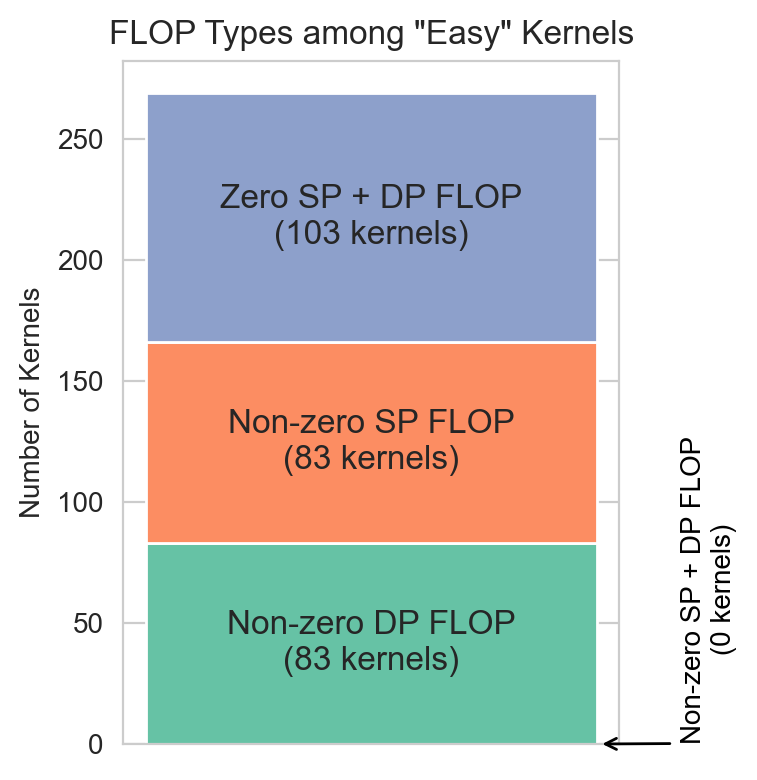

In [36]:
plot_flop_type_distribution(merged_df)

In [37]:
# check the SP-FLOP and DP-FLOP distribution (should be the same)



83
83
(83,)
(83,)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/589268085.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='FLOP Type', loc='upper left')


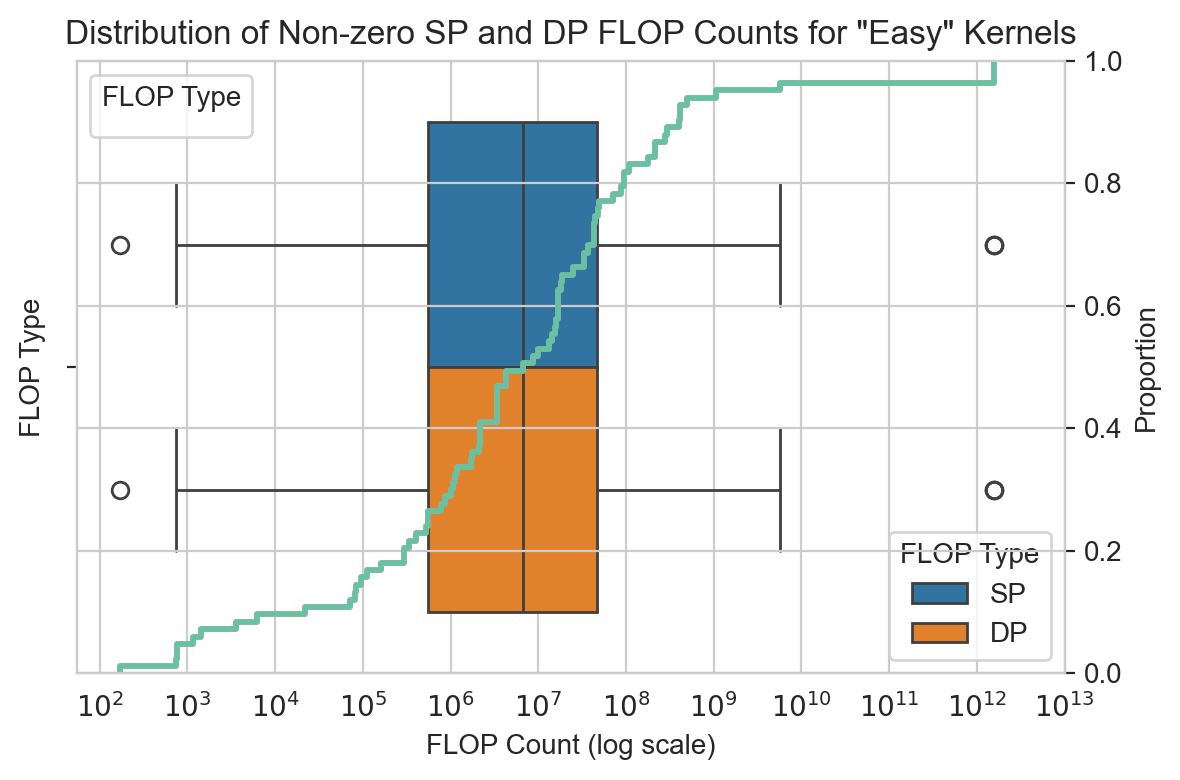

In [38]:
plot_sp_dp_nnz_flop_distribution(merged_df)

In [39]:
# check the distribution of tokens

def plot_token_distribution(df):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=200)

    sns.boxplot(data=df, x='num_tokens', y='nnz_flop_state', order=['Zero SP + DP FLOP', 'Non-zero SP FLOP', 'Non-zero DP FLOP'], ax=ax)


    ax.set_xscale('log')
    ax.set_xlabel('Number of tokens (gpt-4o-mini tokenizer)')
    ax.set_ylabel('Code FLOP Type')

    plt.show()



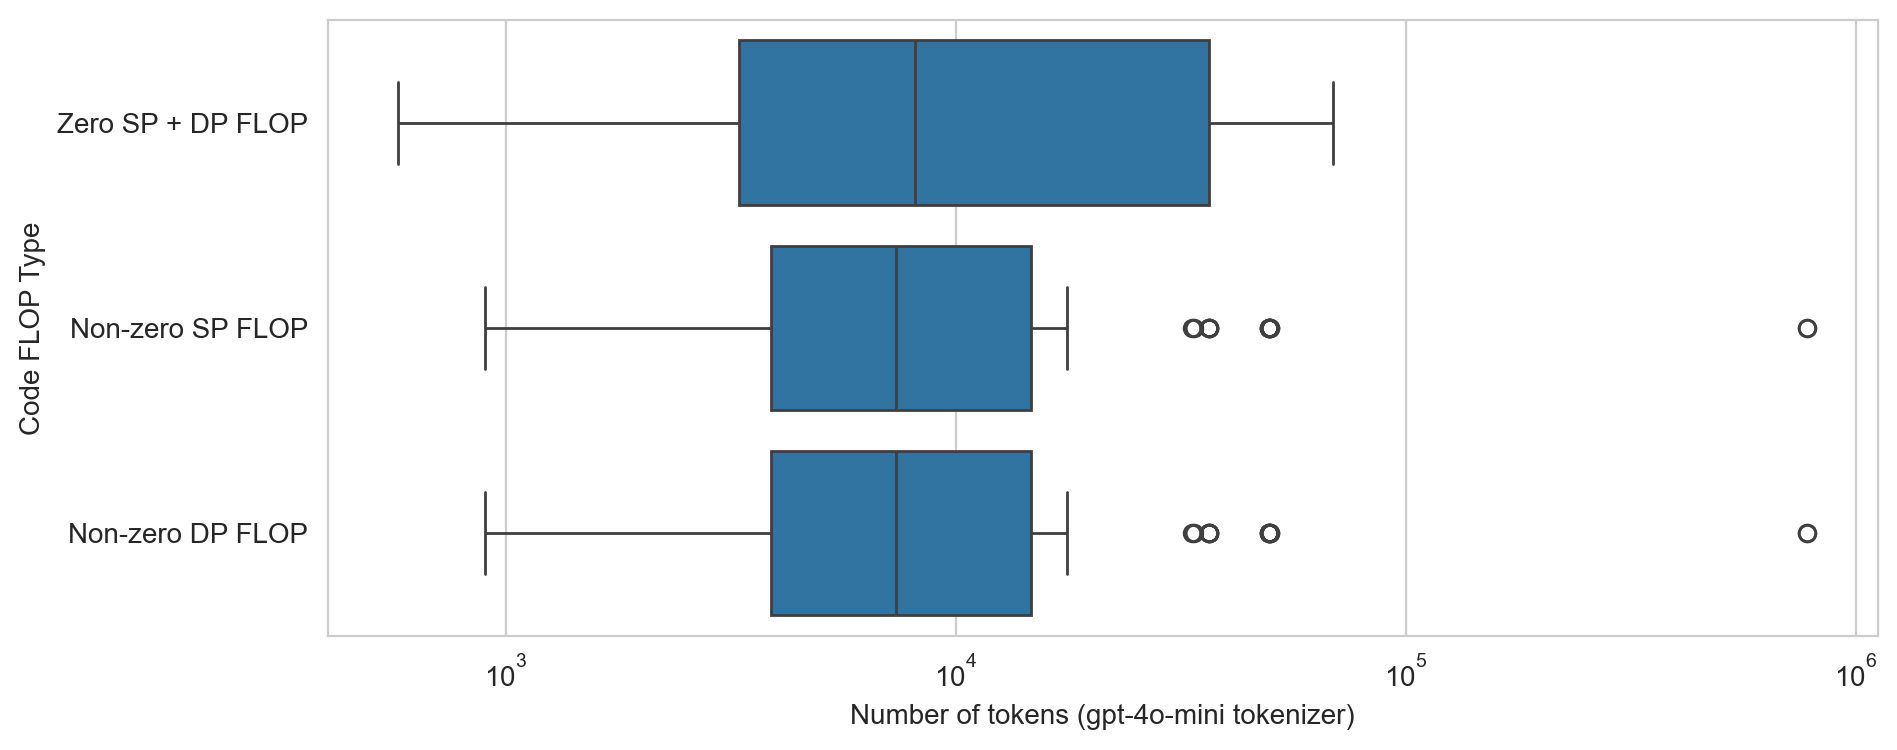

In [40]:
plot_token_distribution(merged_df)

# Drop the outlier codes to get a better balance of token distribution

In [41]:
sp_flop_min_tokens = merged_df[merged_df['nnz_flop_state'] == 'Non-zero SP FLOP']['num_tokens'].min()

merged_df = merged_df[(merged_df['num_tokens'] <= 3e4) & (merged_df['num_tokens'] >= sp_flop_min_tokens)]

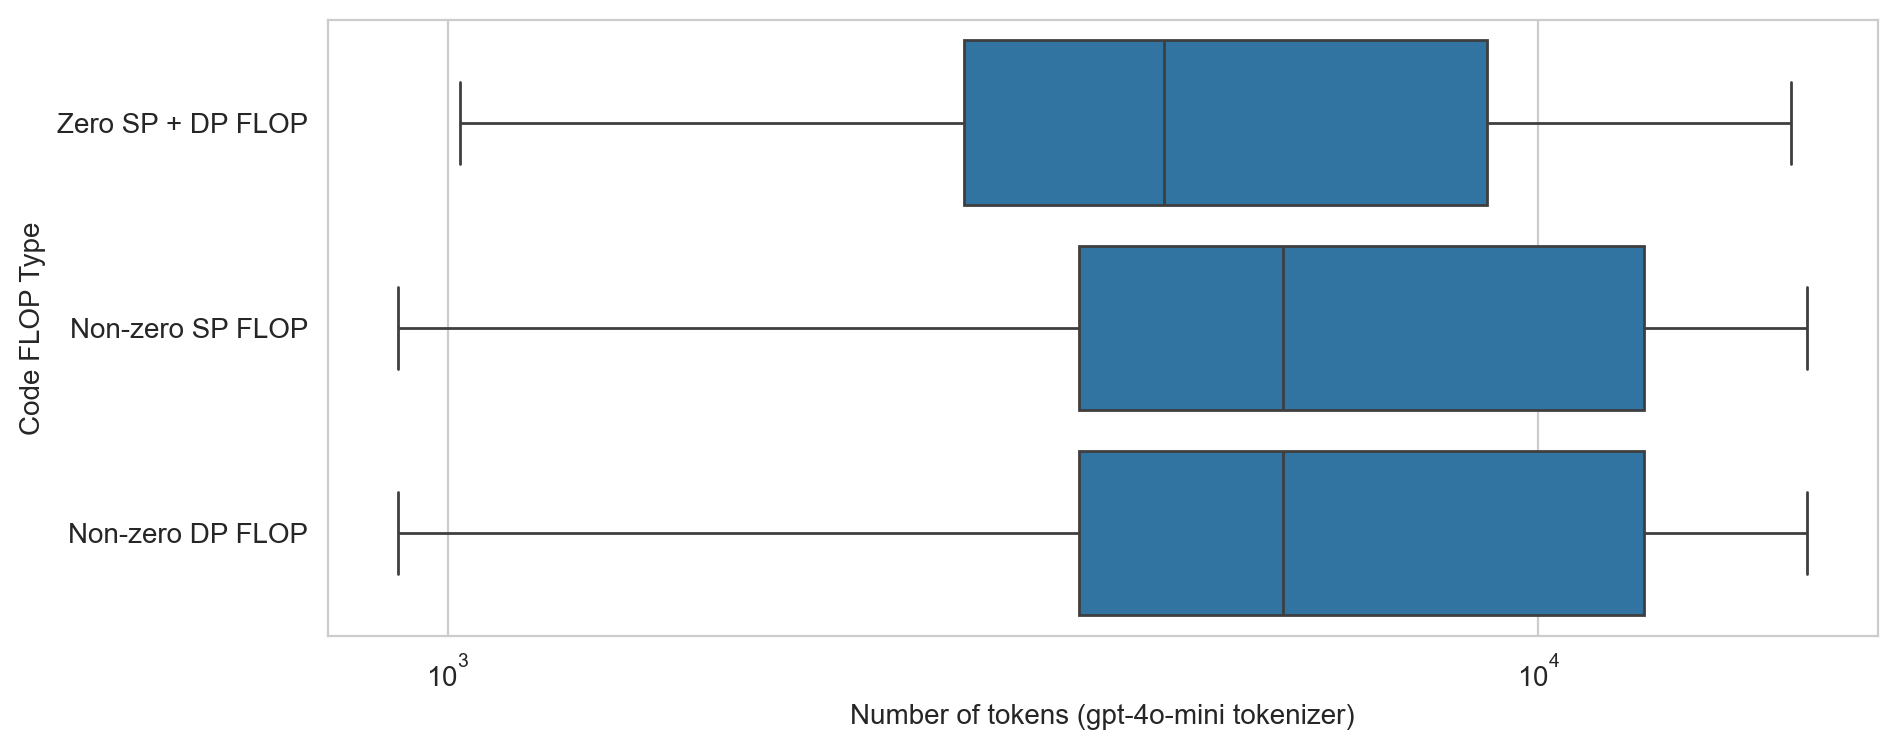

In [42]:
plot_token_distribution(merged_df)

                category  count
0       Non-zero DP FLOP     66
1       Non-zero SP FLOP     66
2      Zero SP + DP FLOP     72
3  Non-zero SP + DP FLOP      0


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/1465215327.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.annotate(f'{cat}\n({str(val)} kernels)', xy=(0.4, 0), xytext=(0.6, 0.2),


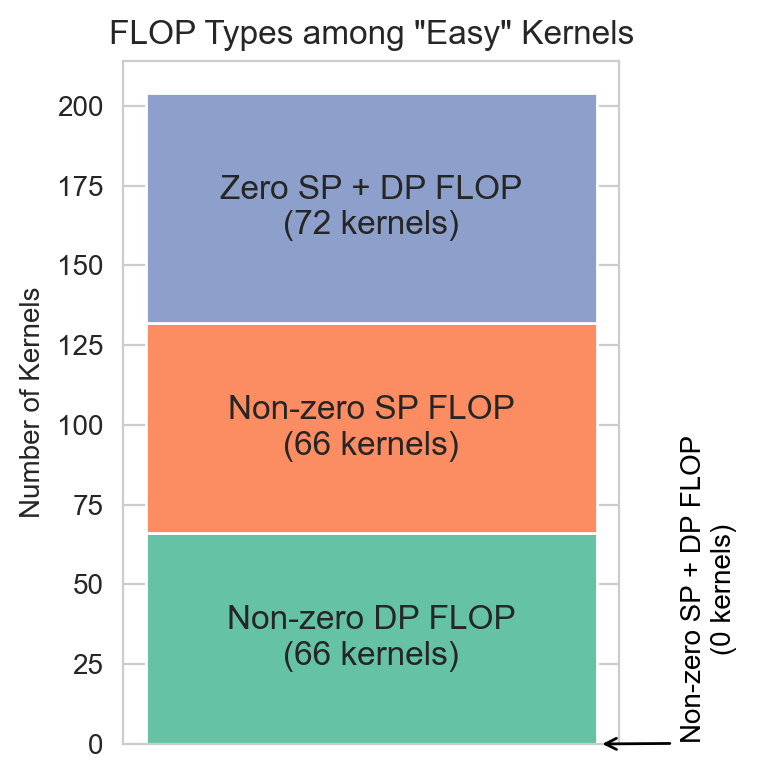

66
66
(66,)
(66,)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_53419/589268085.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='FLOP Type', loc='upper left')


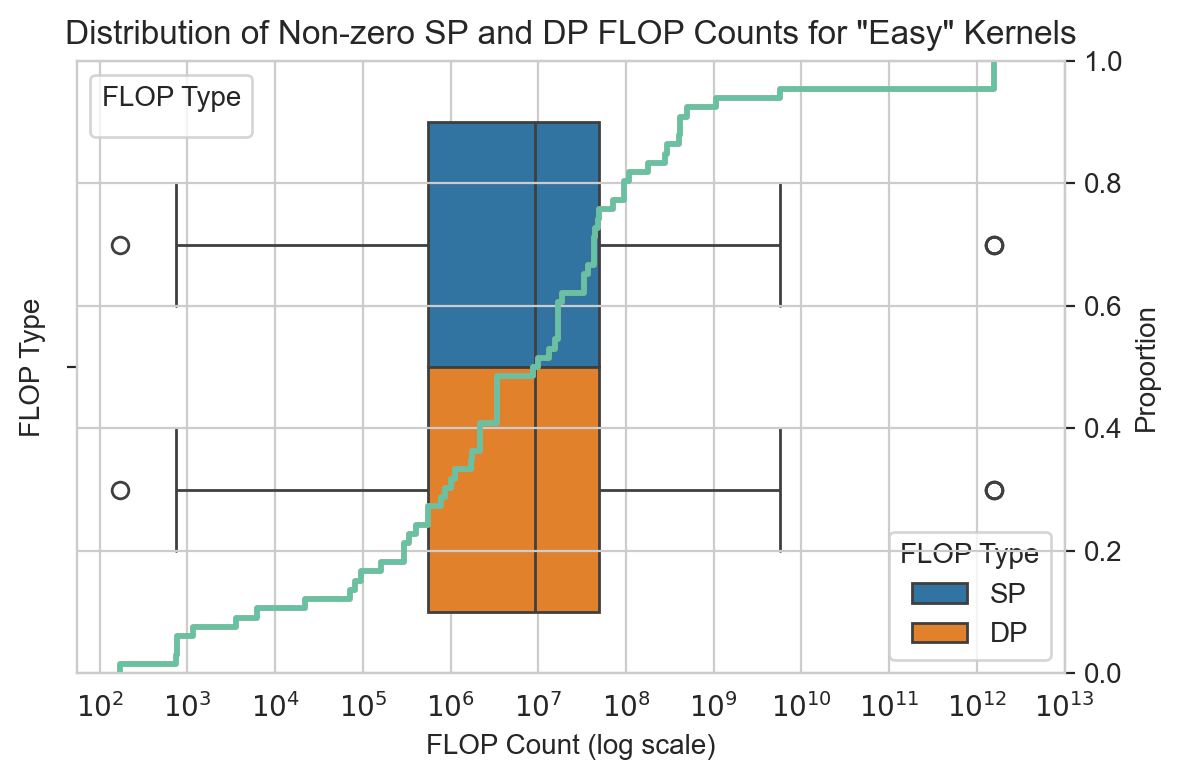

In [43]:
plot_flop_type_distribution(merged_df)
plot_sp_dp_nnz_flop_distribution(merged_df)

## Assumptions we're baking into the dataset

- We tried to balance out the three different classes of codes, having no FLOPs, having only SP FLOPs, and having only DP FLOPs
- The problem that we baked into the dataset is that we have duplicate non-zero FLOP codes -- with just float/double interchanged
- This means that if one step of the prediction pipeline is particularly sensitive to some non-zero FLOP source code feature, both samples will fail, meaning that mis-predicting on nonzero-flop codes will have the mean accuracy dragged down

## Emit dataset + check stats

In [44]:
print(merged_df.columns)
print(len(merged_df.columns))
print(merged_df.dtypes)
print(merged_df.shape)

Index(['Kernel Name', 'targetName', 'exeArgs', 'traffic', 'dpAI', 'spAI',
       'dpPerf', 'spPerf', 'xtime', 'Block Size', 'Grid Size', 'device',
       'intops', 'intPerf', 'intAI', 'kernelName', 'language', 'combined_name',
       'SP_FLOP', 'DP_FLOP', 'nnz_flop_state', 'source_code', 'num_tokens',
       'compile_commands', 'variant'],
      dtype='object')
25
Kernel Name         object
targetName          object
exeArgs             object
traffic             object
dpAI                object
spAI                object
dpPerf              object
spPerf              object
xtime               object
Block Size          object
Grid Size           object
device              object
intops              object
intPerf             object
intAI               object
kernelName          object
language            object
combined_name       object
SP_FLOP             object
DP_FLOP             object
nnz_flop_state      object
source_code         object
num_tokens          object
compile_comm

In [45]:
assert merged_df.shape[0] > 0, "The DataFrame is empty. Please check the CSV file path and content."

assert merged_df.language.isin(['CUDA']).all(), "All kernels should be in CUDA language. Please check the DataFrame."

assert merged_df['SP_FLOP'].sum() == merged_df['DP_FLOP'].sum(), "SP_FLOP and DP_FLOP totals should match after augmentation."


## Save the Dataframe

In [46]:
merged_df.to_csv('./kernels_to_inference_balanced_with_compile_commands.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"', index=False, na_rep='NULL')

NOTE: Had to manually modify `(srad-cuda, srad)` to drop one of its samples. This manual modification was done to the `roofline-data-updated-FINAL.csv`. This happens because we use `-k "regex:srad"` with `ncu` which picks up `srad` and `srad2` during profiling. Manually dropped the second sample from the dataset.
